In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from fbprophet import Prophet

from sklearn.metrics import mean_absolute_error

np.random.seed(123)

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Generating data

In [3]:
def f_1(time):
    """
    time: np.array (len_ts,)
    """
    return time.reshape(-1,1)

def f_2(time):
    noise = np.random.randn(time.shape[0])
    f = lambda t: t * np.sin(t) + 200
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return (f_time+noise).reshape(-1,1)

def f_3(time, period):
    f = lambda t: 100 * np.sin(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def f_4(time, period):
    f = lambda t: 100 * np.cos(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    return y

def generate_ts_2(exog):
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    return y
    

In [4]:
Time = np.arange(0, 200)

# Plotting features

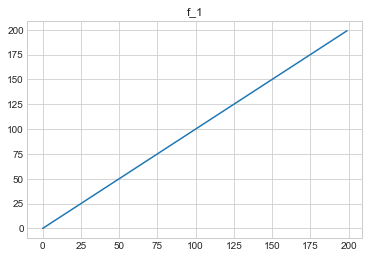

In [5]:
plt.plot(Time,f_1(Time))
plt.title("f_1")
plt.show()

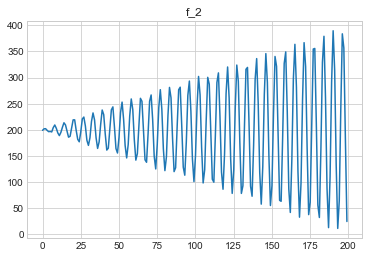

In [6]:
plt.plot(Time,f_2(Time))
plt.title("f_2")
plt.show()

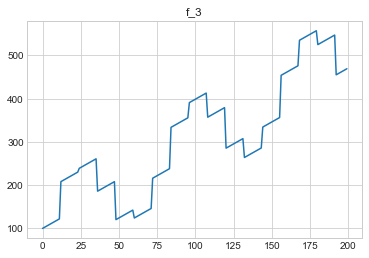

In [7]:
plt.plot(Time,f_3(Time, period=12))
plt.title("f_3")
plt.show()

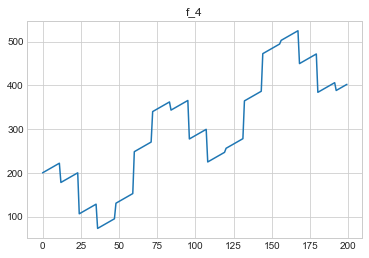

In [8]:
plt.plot(Time,f_4(Time,period=12))
plt.title("f_4")
plt.show()

# Plotting time-series

In [9]:
Exog = np.concatenate([f_1(Time),f_2(Time),f_3(Time, period=12),f_4(Time, period=12)], axis =1)

In [10]:
Exog.shape

(200, 4)

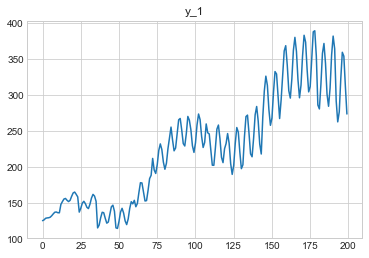

In [11]:
y_1 = generate_ts_1(Exog)

plt.plot(Time,y_1)
plt.title("y_1")
plt.show()

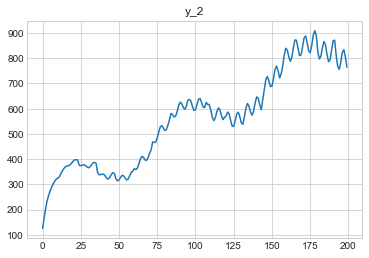

In [12]:
y_2 = generate_ts_2(Exog)

plt.plot(Time,y_2)
plt.title("y_2")
plt.show()

# Prophet Approach

In [13]:
data_1 = pd.DataFrame(y_1)
data_1.columns = ["y"]
data_1["ds"] = pd.date_range(start='1/1/2018', periods=len(data_1), freq='M')

data_2 = pd.DataFrame({"y": y_2})
data_2["ds"] = pd.date_range(start='1/1/2018', periods=len(data_2), freq='M')

exog = pd.DataFrame(Exog)
exog.columns = ["f1", "f2", "f3", "f4"]
exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')

print(data_1.shape, data_2.shape, exog.shape)

(200, 2) (200, 2) (200, 5)


In [14]:
data_1.head()

,y,ds
0,125.175828,2018-01-31
1,126.310841,2018-02-28
2,128.504824,2018-03-31
3,129.027914,2018-04-30
4,129.241621,2018-05-31


In [15]:
data_2.shape

(200, 2)

In [16]:
exog.head()

,f1,f2,f3,f4,ds
0,0.0,200.703310,100.0,200.0,2018-01-31
1,1.0,200.243366,102.0,202.0,2018-02-28
2,2.0,204.019297,104.0,204.0,2018-03-31
3,3.0,201.111657,106.0,206.0,2018-04-30
4,4.0,196.966483,108.0,208.0,2018-05-31


In [17]:
N = 100

data_train_1 = data_1.iloc[:N]
data_test_1 = data_1.iloc[N:]

data_train_2 = data_2.iloc[:N]
data_test_2 = data_2.iloc[N:]

exog_train = exog.iloc[:N]
exog_test = exog.iloc[N:]

In [18]:
y_test_1 = data_test_1["y"].values
del data_test_1["y"]

y_test_2 = data_test_2["y"].values
del data_test_2["y"]

# 1 Experiment: 1-st dataset without exog

In [19]:
# Python
model = Prophet()

#model.add_seasonality(
#    name='montly', period=7, fourier_order=3, prior_scale=0.1)

model.fit(data_train_1)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [20]:
forecast = model.predict(data_test_1)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
95,2034-04-30,531.317414,473.383157,592.723160
96,2034-05-31,545.040123,486.261847,604.649486
97,2034-06-30,547.099527,483.775066,608.814950
98,2034-07-31,544.282996,482.088091,604.664982
99,2034-08-31,541.701026,479.820500,606.426939


In [21]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_1), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.29 
 MAE:  121.744


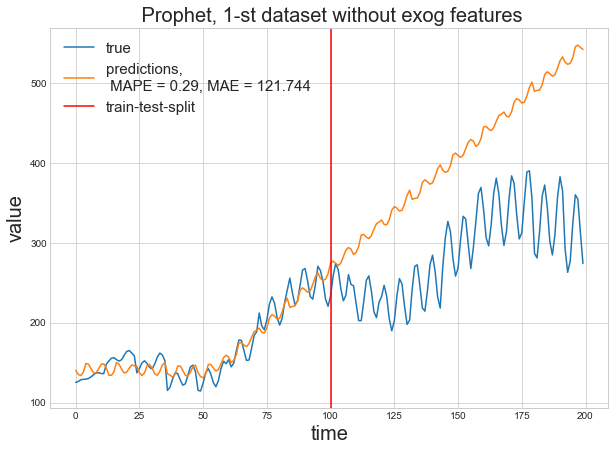

In [22]:
forecast_test = model.predict(data_test_1)
forecast_train = model.predict(data_train_1)

plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time, np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=100, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 1-st dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# 2 Experiment: 2-nd dataset without exog

In [23]:
# Python
model = Prophet()
model.fit(data_train_2)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [24]:
forecast = model.predict(data_test_2)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
95,2034-04-30,1381.197405,975.240263,1866.565145
96,2034-05-31,1403.905956,994.179388,1897.927724
97,2034-06-30,1413.827088,991.546898,1911.707706
98,2034-07-31,1417.977195,996.121718,1924.716946
99,2034-08-31,1419.473600,990.276171,1929.984791


In [25]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_2), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.31 
 MAE:  334.621


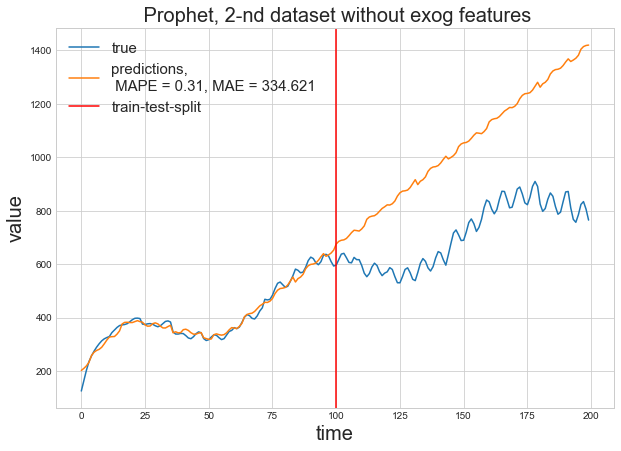

In [26]:
forecast_test = model.predict(data_test_2)
forecast_train = model.predict(data_train_2)

plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time, np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=100, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 2-nd dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# Merging of features

In [27]:
data_train_1_new = pd.merge(data_train_1, exog_train, on = "ds")

data_test_1_new = pd.merge(data_test_1, exog_test, on = "ds")

print(data_train_1_new.shape, data_test_1_new.shape)
data_train_1_new.head()

(100, 6) (100, 5)


,y,ds,f1,f2,f3,f4
0,125.175828,2018-01-31,0.0,200.703310,100.0,200.0
1,126.310841,2018-02-28,1.0,200.243366,102.0,202.0
2,128.504824,2018-03-31,2.0,204.019297,104.0,204.0
3,129.027914,2018-04-30,3.0,201.111657,106.0,206.0
4,129.241621,2018-05-31,4.0,196.966483,108.0,208.0


# 3-rd Experiment: 1-st dataset with exog features

In [28]:
data_train_2_new = pd.merge(data_train_2, exog_train, on = "ds")

data_test_2_new = pd.merge(data_test_2, exog_test, on = "ds")

print(data_train_2_new.shape, data_test_2_new.shape)
data_train_2_new.head()

(100, 6) (100, 5)


,y,ds,f1,f2,f3,f4
0,125.175828,2018-01-31,0.0,200.703310,100.0,200.0
1,163.863590,2018-02-28,1.0,200.243366,102.0,202.0
2,202.699067,2018-03-31,2.0,204.019297,104.0,204.0
3,235.127935,2018-04-30,3.0,201.111657,106.0,206.0
4,256.706173,2018-05-31,4.0,196.966483,108.0,208.0


In [29]:
model = Prophet()

model.add_regressor("f1")
model.add_regressor("f2")
model.add_regressor("f3")
model.add_regressor("f4")

model.fit(data_train_1_new)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [30]:
forecast = model.predict(data_test_1_new)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
95,2034-04-30,323.320186,321.599053,325.119001
96,2034-05-31,359.940383,358.209134,361.780397
97,2034-06-30,354.483554,352.715528,356.358940
98,2034-07-31,312.500018,310.692957,314.430998
99,2034-08-31,273.923753,272.091988,275.871908


In [31]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_1), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.0 
 MAE:  0.065


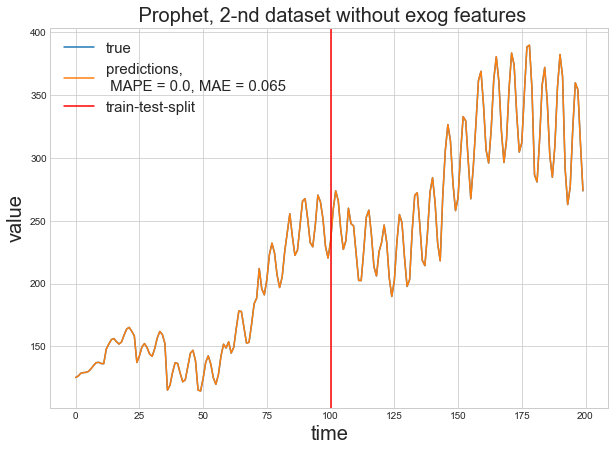

In [32]:
forecast_test = model.predict(data_test_1_new)
forecast_train = model.predict(data_train_1_new)

plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time, np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=100, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 2-nd dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# 3-rd Experiment: 2-nd dataset with exog features

In [33]:
model = Prophet()

model.add_regressor("f1")
model.add_regressor("f2")
model.add_regressor("f3")
model.add_regressor("f4")

model.fit(data_train_2_new)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [34]:
forecast = model.predict(data_test_2_new)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
95,2034-04-30,1062.699906,628.003416,1496.884132
96,2034-05-31,1101.609583,660.368922,1544.261278
97,2034-06-30,1103.390417,662.445490,1548.257673
98,2034-07-31,1072.682861,625.772516,1527.052527
99,2034-08-31,1042.837881,585.674677,1505.157755


In [35]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_2), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.171 
 MAE:  151.835


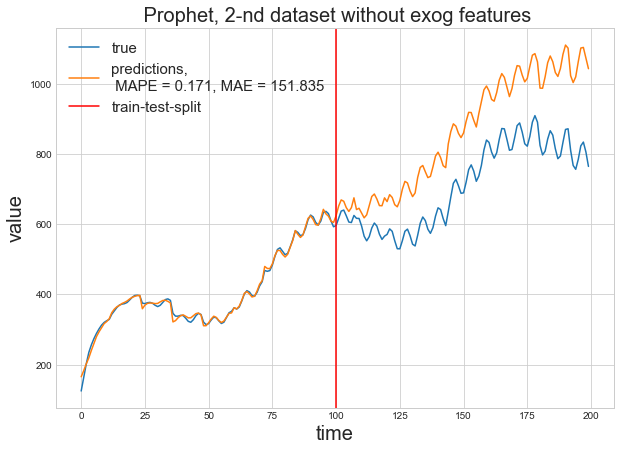

In [36]:
forecast_test = model.predict(data_test_2_new)
forecast_train = model.predict(data_train_2_new)

plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time, np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=100, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 2-nd dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# Model Params:

In [37]:
model.params

{'k': array([[1.24747747]]),
 'm': array([[1.00312869]]),
 'delta': array([[-1.01107624e-07, -6.55061306e-01, -1.05068725e+00,
         -4.74558719e-01, -5.23091772e-07, -3.44211981e-07,
         -1.72372010e-01, -3.12668596e-01, -2.22249982e-07,
         -5.92865324e-09, -2.33259019e-07, -6.45415260e-08,
          2.76716165e-08,  4.11446285e-07,  6.01005055e-08,
          1.44843820e-06,  8.06791176e-02,  2.48833381e-01,
          1.96228373e-01,  1.11062236e-01,  4.86279077e-04,
          3.48388145e-02,  1.44107625e-04, -3.61094958e-09,
          5.88144285e-09]]),
 'sigma_obs': array([[0.01235277]]),
 'beta': array([[-2.56904649e-03, -2.99875544e-03, -1.39024611e-02,
         -2.44603836e-02, -2.05774596e-03, -6.89359504e-03,
         -6.23877856e-03, -6.29286249e-03, -7.18267094e-03,
          3.56908948e-04, -3.87204358e-03,  5.25900179e-04,
         -5.93937418e-03,  9.30121244e-04, -6.48283184e-03,
          5.99849396e-03, -2.00883504e-03,  6.53465033e-03,
         -2.3138447